![oops couldn't find image](Data-Science-Essentials-2020-header.png)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import scipy as sp
import geopandas as gpd
import numpy as np
from textwrap import wrap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from cm import plot_confusion_matrix

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

# Assignment

## Comparing Cost Burden Across TN Counties for Myocardial Infarction and Selected Cancers

### **TN Med Helper** is a fictional company that assists patients who are cost-burdened as a result of unexpected medical events. TN Med Helper has approached your data science consultancy for help understanding how to measure the relative burden experienced by patients in TN counties in order to allocate money for relief.

### The two most deadly [diseases](https://www.cdc.gov/nchs/pressroom/states/tennessee/tennessee.htm) in Tennessee, according to the Centers for Disease Control and Prevention (CDC) are Heart Disease and Cancer. In this project, we will explore the [Medicare Disparities](https://data.cms.gov/mapping-medicare-disparities) data for acute myocardial infarction (heart attacks) and for colorectal, breast, prostrate, and lung cancers. The medicare disparities datasets for the two conditions above include a one-year total cost of care by county for patients with these conditions. Total cost is stored in the column called `analysis_value` for each dataset. The disparities data highlights the fact that the cost for different illnesses varies across geographic regions.

### We will also be using the Internal Revenue Service (IRS) data for [individual tax returns for 2016](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-return-form-1040-statistics). This data includes the number of returns filed by 7 different income groups, a break down by filing status for the returns filed, and the total income reported for each income group by filing status. We will be calculating the average income reported by county, but you may decide to incorporate other aspects of this data into your analysis as time allows.  

### By looking at the total cost of care for heart attacks and for cancer we begin to understand cost-of-care disparities. In this project we will look at earnings disparities by examining the IRS income data, and then exploring cost-of-care within the added context of reported earnings by county. We will create a ratio of total-cost-of-care over average income for each county for the two conditions we are looking at in this project.

### Next we will build a classifier that **classifies whether a county is above or below the average `cost_income_ratio`** for each disease under consideration. We will create a baseline classifier with our initial datasets, then seek and explore additional data to improve the performance of the classifier.  


## 1. Load and clean the original healthcare cost and income data

In [2]:
# 1a. Load/clean the heart attack and cancer costs data
state_abbr = pd.read_csv('../data/state_abbrev.csv')
ha_costs_df = pd.read_csv('../data/mmd_heart_attack_data.csv')
cancer_costs_df = pd.read_csv('../data/mmd_cancer_data.csv')

# Rename analysis_value column for cost data
ha_costs_df = ha_costs_df.rename(columns = {'analysis_value': 'ha_avg_cost'})
cancer_costs_df = cancer_costs_df.rename(columns = {'analysis_value': 'cancer_avg_cost'})

# Merge the two costs datasets
costs_df = pd.merge(left=cancer_costs_df[['state','county','urban','cancer_avg_cost']], 
                    right=ha_costs_df[['state','county','ha_avg_cost']], 
                    left_on=['state','county'], right_on=['state','county'], how='outer')

# Remove those rows which don't contain "County" in the name
costs_df = costs_df[costs_df['county'].str.contains('County')]

# Change state names to abbrevition (as it is in income data)
state_dict = state_abbr.set_index('name').T.to_dict('list')
costs_df.state = costs_df.state.replace(state_dict)  

# 1b. Load/clean the income data
# Read in income data and change some column names
income_df = pd.read_csv('../data/irs_county_2016.csv')
keep_cols = ['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'N2', 'NUMDEP', 'ELDERLY', 'A00100', 'N02650', 'A02650', 'N02300', 'A02300']
income_df = income_df.loc[:,keep_cols]
income_df.columns = ['state', 'county', 'income_bucket', 'return_count', 'single_returns', 'joint_returns', 'head_of_house_returns', 'exemptions', 'dependents', 'elderly', 'agi', 'returns_with_total_inc','total_inc_amt', 'returns_with_unemployment', 'unemployment_comp']

# Aggregate income data by county
income_county_df = income_df.groupby(['state', 'county']).sum().reset_index()

# Create new average income column
income_county_df['avg_inc'] = 1000 * income_county_df.total_inc_amt/income_county_df.return_count

# Create reduced version of income data
income_sub = income_county_df[['state','county', 'avg_inc','elderly','dependents','returns_with_unemployment']]

# Remove those rows which don't contain "County" in the name
income_sub = income_sub[income_sub['county'].str.contains('County')].reset_index()
income_sub

,index,state,county,avg_inc,elderly,dependents,returns_with_unemployment
0,31,AL,Autauga County,55680.240764,5340,17390,430
1,32,AL,Baldwin County,62603.044838,29090,57200,1980
2,33,AL,Barbour County,40094.136808,2400,6970,260
3,34,AL,Bibb County,47260.201511,1670,6120,290
4,35,AL,Blount County,49333.197648,5350,16330,540
...,...,...,...,...,...,...,...
2987,3185,WY,Sweetwater County,67995.656617,4310,14380,1200
2988,3186,WY,Teton County,214588.045007,3120,7870,720
2989,3187,WY,Uinta County,60912.403101,2280,7260,520
2990,3188,WY,Washakie County,62248.501362,1220,2260,190


## 2. Load additional data from the County Health Rankings spreadsheets

### Sheet 1 - Outcomes & Factors Rankings

In [3]:
hranks = pd.read_excel('../data/2018 County Health Rankings Data - v2.xls', sheet_name = 1, header = [0,1])
# First, combine the two column name levels
col_names = [' '.join(col).strip() for col in hranks.columns.values]
# Then get rid of the "Unnamed" portion for the first 4 columns
col_names[0:4] = ['FIPS', 'State', 'County', '# of Ranked Counties']
hranks.columns = col_names
# Convert state column to abbreviation
hranks['State']=hranks.State.str.upper().map(state_abbr.set_index('name')['abbrev'].to_dict())

hranks.head(-1)

,FIPS,State,County,# of Ranked Counties,Health Outcomes Rank,Health Outcomes Quartile,Health Factors Rank,Health Factors Quartile
0,1001,AL,Autauga,67,11,1,8,1
1,1003,AL,Baldwin,67,3,1,3,1
2,1005,AL,Barbour,67,34,2,56,4
3,1007,AL,Bibb,67,41,3,37,3
4,1009,AL,Blount,67,14,1,19,2
...,...,...,...,...,...,...,...,...
3136,56035,WY,Sublette,23,2,1,7,2
3137,56037,WY,Sweetwater,23,15,3,21,4
3138,56039,WY,Teton,23,1,1,1,1
3139,56041,WY,Uinta,23,21,4,17,3


### Sheet 2 - Outcomes & Factors SubRankings

In [4]:
hranks2 = pd.read_excel('../data/2018 County Health Rankings Data - v2.xls', sheet_name = 2, header = [0,1])
# First, combine the two column name levels
col_names = [' '.join(col).strip() for col in hranks2.columns.values]
# Then get rid of the "Unnamed" portion for the first 4 columns
col_names[0:4] = ['FIPS', 'State', 'County', '# of Ranked Counties']
hranks2.columns = col_names
# Convert state column to abbreviation
hranks2['State']=hranks2.State.str.upper().map(state_abbr.set_index('name')['abbrev'].to_dict())

hranks2.head(-1)

,FIPS,State,County,# of Ranked Counties,Length of Life Rank,Length of Life Quartile,Quality of Life Rank,Quality of Life Quartile,Health Behaviors Rank,Health Behaviors Quartile,Clinical Care Rank,Clinical Care Quartile,Social & Economic Factors Rank,Social & Economic Factors Quartile,Physical Environment Rank,Physical Environment Quartile
0,1001,AL,Autauga,67,18,2,5,1,12,1,15,1,3,1,51,4
1,1003,AL,Baldwin,67,4,1,4,1,3,1,7,1,8,1,14,1
2,1005,AL,Barbour,67,14,1,49,3,57,4,20,2,58,4,16,1
3,1007,AL,Bibb,67,53,4,25,2,39,3,42,3,42,3,29,2
4,1009,AL,Blount,67,17,1,12,1,11,1,41,3,13,1,54,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,56035,WY,Sublette,23,2,1,4,1,5,1,9,2,8,2,17,3
3137,56037,WY,Sweetwater,23,6,1,18,4,20,4,11,2,20,4,19,4
3138,56039,WY,Teton,23,1,1,2,1,1,1,1,1,1,1,15,3
3139,56041,WY,Uinta,23,18,4,21,4,19,4,6,1,17,3,13,3


### Sheet 3 - Ranked Measure Data

In [5]:
hranks3 = pd.read_excel('../data/2018 County Health Rankings Data - v2.xls', sheet_name = 3, header = [0,1])
# First, combine the two column name levels
col_names = [' '.join(col).strip() for col in hranks3.columns.values]
# Then get rid of the "Unnamed" portion for the first 3 columns
col_names[0:3] = ['FIPS', 'State', 'County']
hranks3.columns = col_names
# Convert state column to abbreviation
hranks3['State']=hranks3.State.str.upper().map(state_abbr.set_index('name')['abbrev'].to_dict())

hranks3.head(-1)

,FIPS,State,County,Premature death Years of Potential Life Lost Rate,Premature death 95% CI - Low,Premature death 95% CI - High,Premature death Quartile,Premature death Years of Potential Life Lost Rate (Black),Premature death Years of Potential Life Lost Rate (Hispanic),Premature death Years of Potential Life Lost Rate (White),...,Driving alone to work 95% CI - High,Driving alone to work Quartile,Driving alone to work % Drive Alone (Black),Driving alone to work % Drive Alone (Hispanic),Driving alone to work % Drive Alone (White),Long commute - driving alone # Workers who Drive Alone,Long commute - driving alone % Long Commute - Drives Alone,Long commute - driving alone 95% CI - Low,Long commute - driving alone 95% CI - High,Long commute - driving alone Quartile
0,1001.0,AL,Autauga,9409.294766,8492.111635,10326.477898,2,11806.223285,NaN,9148.381743,...,88.431482,4,82.494851,NaN,82.539683,21082.0,40.8,36.698437,44.901563,3
1,1003.0,AL,Baldwin,7467.596664,7025.900408,7909.292920,1,10335.702691,2827.348216,7484.117065,...,86.017804,2,85.567010,68.864800,84.646255,73058.0,40.1,37.614952,42.585048,3
2,1005.0,AL,Barbour,8929.474982,7633.929691,10225.020273,1,9141.333085,NaN,8896.000532,...,85.796041,1,80.341227,NaN,85.656228,7271.0,35.1,29.740946,40.459054,2
3,1007.0,AL,Bibb,11741.938889,10057.801626,13426.076153,4,11297.166352,NaN,11923.067966,...,89.905820,2,NaN,NaN,NaN,7044.0,48.8,40.894758,56.705242,4
4,1009.0,AL,Blount,9359.122343,8463.490290,10254.754396,1,NaN,5133.144570,9600.725685,...,87.622499,3,NaN,79.539642,81.580997,18384.0,60.2,55.818947,64.581053,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037.0,WY,Sweetwater,6682.397752,5848.326360,7516.469144,1,NaN,4249.103214,7169.977818,...,80.387201,3,NaN,71.180453,76.392270,17537.0,18.5,15.801336,21.198664,2
3138,56039.0,WY,Teton,3823.238218,2806.927407,4839.549029,1,NaN,NaN,NaN,...,68.571890,1,NaN,57.172131,65.065532,8984.0,11.5,7.798704,15.201296,1
3139,56041.0,WY,Uinta,8365.629795,6952.016456,9779.243135,4,NaN,NaN,NaN,...,78.929607,2,NaN,NaN,NaN,7049.0,17.6,12.927295,22.272705,2
3140,56043.0,WY,Washakie,6341.903776,5093.069491,7804.258313,1,NaN,NaN,NaN,...,81.564196,3,NaN,NaN,NaN,2783.0,9.7,5.480714,13.919286,1


### Sheet 5 - Additional Measure Data

In [6]:
hranks5 = pd.read_excel('../data/2018 County Health Rankings Data - v2.xls', sheet_name = 5, header = [0,1])
# First, combine the two column name levels
col_names = [' '.join(col).strip() for col in hranks5.columns.values]
# Then get rid of the "Unnamed" portion for the first 3 columns
col_names[0:3] = ['FIPS', 'State', 'County']
hranks5.columns = col_names
# Convert state column to abbreviation
hranks5['State']=hranks5.State.str.upper().map(state_abbr.set_index('name')['abbrev'].to_dict())

hranks5.head(-1)

,FIPS,State,County,Premature age-adjusted mortality # Deaths,Premature age-adjusted mortality Age-Adjusted Mortality,Premature age-adjusted mortality 95% CI - Low,Premature age-adjusted mortality 95% CI - High,Premature age-adjusted mortality Age-Adjusted Mortality (Black),Premature age-adjusted mortality Age-Adjusted Mortality (Hispanic),Premature age-adjusted mortality Age-Adjusted Mortality (White),...,Demographics % Hispanic,Demographics # Non-Hispanic White,Demographics % Non-Hispanic White,Demographics # Not Proficient in English,Demographics % Not Proficient in English,Demographics 95% CI - Low,Demographics 95% CI - High,Demographics % Female,Demographics # Rural,Demographics % Rural
0,1001,AL,Autauga,827.0,449.6,418.5,480.7,531.7,NaN,444.9,...,2.688754,41562,75.000000,432,0.832739,0.457689,1.207789,51.288437,22921.0,42.002162
1,1003,AL,Baldwin,2753.0,351.3,337.5,365.1,517.8,111.1,349.3,...,4.416411,173529,83.202198,1540,0.818809,0.508623,1.128996,51.457833,77060.0,42.279099
2,1005,AL,Barbour,418.0,433.6,390.5,476.6,477.0,NaN,394.7,...,4.213364,12061,46.450992,382,1.519370,0.790980,2.247760,46.932409,18613.0,67.789635
3,1007,AL,Bibb,408.0,529.1,476.7,581.4,630.4,NaN,526.6,...,2.499669,16850,74.415934,96,0.448137,0.000000,1.041411,46.363114,15663.0,68.352607
4,1009,AL,Blount,996.0,480.2,449.2,511.2,NaN,NaN,NaN,...,9.068695,50472,87.467073,1018,1.878506,1.332987,2.424025,50.613476,51562.0,89.951502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,56035,WY,Sublette,73.0,219.1,170.5,277.3,NaN,NaN,NaN,...,8.086805,8602,88.054049,58,0.619460,0.000000,1.737041,46.565667,10247.0,100.000000
3137,56037,WY,Sweetwater,480.0,356.5,323.9,389.0,NaN,262.4,376.8,...,16.076078,35152,79.592437,890,2.140040,1.512748,2.767333,48.178422,4782.0,10.916313
3138,56039,WY,Teton,124.0,154.2,126.2,182.2,NaN,NaN,NaN,...,15.122246,18896,81.479884,776,3.622952,2.101954,5.143949,48.402397,9887.0,46.430920
3139,56041,WY,Uinta,259.0,396.8,347.1,446.5,NaN,NaN,NaN,...,9.016512,18182,87.527078,257,1.329196,0.240454,2.417937,49.429548,9101.0,43.095937


## 3. Merge the cost, income, and health rankings data based on state and county.

In [7]:
# Merge costs and income data
cost_income_rank_df = pd.merge(left=income_sub, 
                               right=costs_df, 
                               left_on = ['state','county'], 
                               right_on =['state','county'], how = 'inner')

# Remove "County" from county names
cost_income_rank_df.county = cost_income_rank_df['county'].str.replace(' County', '', regex=True)
# Make state and county column names start with uppercase
cost_income_rank_df.rename(columns={'state':'State'}, inplace=True)
cost_income_rank_df.rename(columns={'county':'County'}, inplace=True)

# Merge rank data
cost_income_rank_df = pd.merge(left=cost_income_rank_df, 
                               right=hranks, 
                               left_on = ['State','County'], 
                               right_on =['State','County'], how = 'inner')
cost_income_rank_df = pd.merge(left=cost_income_rank_df, 
                               right=hranks2, 
                               left_on = ['State','County'], 
                               right_on =['State','County'], how = 'inner')
cost_income_rank_df = pd.merge(left=cost_income_rank_df, 
                               right=hranks3, 
                               left_on = ['State','County'], 
                               right_on =['State','County'], how = 'inner')
cost_income_rank_df = pd.merge(left=cost_income_rank_df, 
                               right=hranks5, 
                               left_on = ['State','County'], 
                               right_on =['State','County'], how = 'inner')


# Create the cost to income ratios
cost_income_rank_df['ha_cost_inc_ratio'] = cost_income_rank_df.ha_avg_cost / cost_income_rank_df.avg_inc;
cost_income_rank_df['cancer_cost_inc_ratio'] = cost_income_rank_df.cancer_avg_cost / cost_income_rank_df.avg_inc;
cost_income_rank_df.reindex()
cost_income_rank_df.head(-1)

# Replace the NR values present in the Quartile columns
cost_income_rank_df = cost_income_rank_df.replace('NR',np.nan)
cost_income_rank_df = cost_income_rank_df.apply(pd.to_numeric,errors='ignore')

## 4. Set up model inputs

In [8]:
# Change max number of rows shown by pandas
# pd.set_option('display.max_rows', 300)

# Drop the information about county and state
costs_inc_mdl = cost_income_rank_df
costs_inc_mdl = costs_inc_mdl.drop(columns = ['index','State','County']) # 'state'
costs_inc_mdl = pd.get_dummies(costs_inc_mdl, columns = ['urban'], drop_first = True)

# Create the target variable, i.e. above or below the mean cost/income ratio
costs_inc_mdl['abv_avg_ca'] = costs_inc_mdl.cancer_cost_inc_ratio > costs_inc_mdl.cancer_cost_inc_ratio.mean()
costs_inc_mdl['abv_avg_ha'] = costs_inc_mdl.ha_cost_inc_ratio > costs_inc_mdl.ha_cost_inc_ratio.mean()

# Remove columns with NaN, specify that 80% of counties must have usable values
limitPer = len(costs_inc_mdl) * .80
costs_inc_mdl = costs_inc_mdl.dropna(thresh=limitPer,axis=1)
costs_inc_mdl = costs_inc_mdl.dropna()
costs_inc_mdl = costs_inc_mdl.select_dtypes(include=['number','bool'])
costs_inc_mdl


,avg_inc,elderly,dependents,returns_with_unemployment,cancer_avg_cost,ha_avg_cost,FIPS_x,# of Ranked Counties_x,Health Outcomes Rank,Health Outcomes Quartile,...,Demographics 95% CI - Low,Demographics 95% CI - High,Demographics % Female,Demographics # Rural,Demographics % Rural,ha_cost_inc_ratio,cancer_cost_inc_ratio,urban_Urban,abv_avg_ca,abv_avg_ha
0,55680.240764,5340,17390,430,19293,40470.0,1001,67,11.0,1.0,...,0.457689,1.207789,51.288437,22921.0,42.002162,0.726829,0.346496,1,False,False
1,62603.044838,29090,57200,1980,17151,36615.0,1003,67,3.0,1.0,...,0.508623,1.128996,51.457833,77060.0,42.279099,0.584876,0.273964,0,False,False
2,40094.136808,2400,6970,260,19469,46509.0,1005,67,34.0,2.0,...,0.790980,2.247760,46.932409,18613.0,67.789635,1.159995,0.485582,0,True,True
3,47260.201511,1670,6120,290,17234,42949.0,1007,67,41.0,3.0,...,0.000000,1.041411,46.363114,15663.0,68.352607,0.908777,0.364662,1,False,False
4,49333.197648,5350,16330,540,20317,50067.0,1009,67,14.0,1.0,...,1.332987,2.424025,50.613476,51562.0,89.951502,1.014874,0.411832,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955,67220.108696,5080,7140,760,19707,64836.0,56029,23,5.0,1.0,...,0.012667,1.036820,50.199298,12478.0,44.240383,0.964533,0.293171,0,False,False
2956,52024.401914,1480,2100,190,23937,47718.0,56031,23,18.0,4.0,...,0.000000,1.913595,49.009217,5083.0,58.647744,0.917223,0.460111,0,True,False
2957,68287.817938,4850,7410,770,19864,59314.0,56033,23,9.0,2.0,...,0.000000,0.817466,49.731788,10330.0,35.478775,0.868588,0.290886,0,False,False
2959,67995.656617,4310,14380,1200,23139,57980.0,56037,23,15.0,3.0,...,1.512748,2.767333,48.178422,4782.0,10.916313,0.852702,0.340301,0,False,False


## 5. Build/Train the model

## (we will only be predicting the cancer data in this project)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import SVG


### Build

In [10]:
# Set the X (predictor) and y (target) variables
X = costs_inc_mdl.drop(columns = ['avg_inc','cancer_avg_cost','ha_avg_cost','abv_avg_ha','abv_avg_ca',
                                  'ha_cost_inc_ratio','cancer_cost_inc_ratio'])

# Drop any column that included the word "income" or "poverty", as this is highly related to our cost burden measure
X = X.loc[:,~X.columns.str.contains('income')]
X = X.loc[:,~X.columns.str.contains('Income')]
X = X.loc[:,~X.columns.str.contains('Poverty')]
X = X.loc[:,~X.columns.str.contains('poverty')]

# Remove features that aren't actionable/related to resources
searchfor = ['Health Outcomes', 'Health Factors','Length of Life','Quality of Life','Health Behaviors','Social & Economic Factors'
             'Physical Environment','Premature death','Poor or fair health','Children in poverty','mortality','Health care costs',
             'Demographics','college','Teen','teen','price','Social & Economic','Clinical Care','elderly']
X = X.loc[:,~X.columns.str.contains('|'.join(searchfor))]


y = costs_inc_mdl.abv_avg_ca

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, test_size = 0.1)

### Train Random Forest with adjusted settings

In [11]:
forest = RandomForestClassifier(n_estimators = 1000, max_depth = 7, min_samples_leaf = 10)
forest.fit(X_train, y_train)
y_pred_train = forest.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))
y_pred = forest.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8899352560329605
0.798941798941799


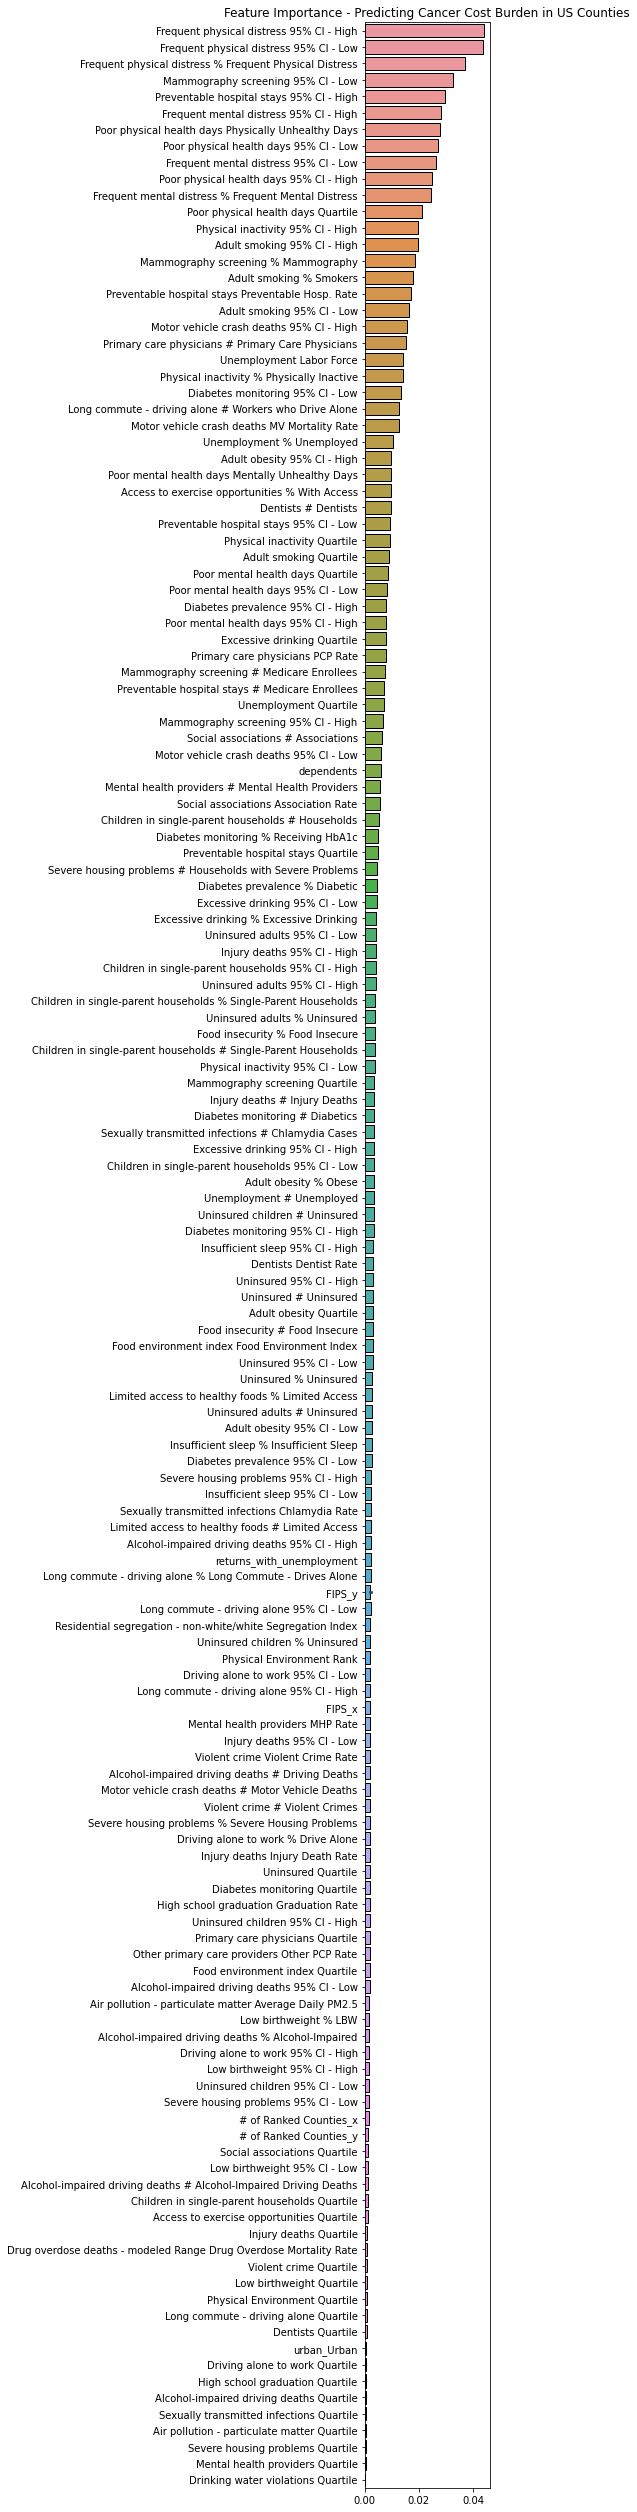

In [12]:
# Get sorted index of features based on importance (negate so the list is highest to lowest)
ind = np.argsort(-forest.feature_importances_)

# Plot bar chart of importances
fig, ax = plt.subplots(figsize = (7,35))
sns.barplot(x = forest.feature_importances_[ind], y = list(X.columns[ind]), ax = ax, edgecolor = 'black')
plt.title('Feature Importance - Predicting Cancer Cost Burden in US Counties');
plt.savefig('feature_importance_pred_cancer_cost_burden_randforest_all_feats.png')

-------
# Now build a new model but eliminate any highly correlated features. If correlated, keep the feature showing highest importance in previous model

In [13]:
# Sort the feature matrix by the index of importance from previous model
X_sorted = X.iloc[:,ind]

# Create correlation matrix
corr_matrix = X_sorted.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop features 
X_sorted_drop = X_sorted.drop(X_sorted[to_drop], axis=1)
X_sorted_drop

,Frequent physical distress 95% CI - High,Mammography screening 95% CI - Low,Preventable hospital stays 95% CI - High,Poor physical health days Quartile,Physical inactivity 95% CI - High,Adult smoking 95% CI - High,Motor vehicle crash deaths 95% CI - High,Primary care physicians # Primary Care Physicians,Diabetes monitoring 95% CI - Low,Unemployment % Unemployed,...,Dentists Quartile,urban_Urban,Driving alone to work Quartile,High school graduation Quartile,Alcohol-impaired driving deaths Quartile,Sexually transmitted infections Quartile,Air pollution - particulate matter Quartile,Severe housing problems Quartile,Mental health providers Quartile,Drinking water violations Quartile
0,13.181426,55.401654,91.09,1.0,35.9,19.784979,25.2,25.0,77.230686,5.271161,...,2.0,1,4.0,3.0,3.0,2.0,3.0,3.0,3.0,1.0
1,12.997419,62.560457,49.46,1.0,27.4,17.363437,17.4,148.0,79.715896,5.415263,...,1.0,0,2.0,4.0,3.0,1.0,1.0,2.0,1.0,1.0
2,16.620304,54.464387,67.85,4.0,35.5,22.273791,25.9,11.0,81.066422,8.648518,...,2.0,0,1.0,4.0,4.0,3.0,2.0,3.0,4.0,1.0
3,13.549926,50.427685,108.89,1.0,43.3,20.682116,36.5,12.0,72.256902,6.637117,...,3.0,1,2.0,4.0,3.0,1.0,3.0,1.0,4.0,1.0
4,14.196881,52.313565,65.42,2.0,35.0,20.494065,27.7,12.0,80.748251,5.520897,...,3.0,1,3.0,2.0,1.0,1.0,4.0,1.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955,10.494335,58.180797,46.58,2.0,26.2,14.917116,24.1,35.0,73.575801,4.685843,...,1.0,0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0
2956,11.200118,42.903649,68.39,3.0,30.2,16.610189,36.3,4.0,58.414243,4.806492,...,4.0,0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0
2957,10.596674,50.918431,35.95,2.0,24.0,16.860965,22.8,21.0,68.400535,4.648148,...,1.0,0,4.0,1.0,4.0,3.0,4.0,4.0,1.0,3.0
2959,10.893118,54.155173,55.92,3.0,29.5,18.245740,26.9,15.0,72.876880,5.982484,...,3.0,0,3.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0


In [14]:
# Set the X (predictor) and y (target) variables
X2 = X_sorted_drop
y2 = costs_inc_mdl.abv_avg_ca

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state = 8, test_size = 0.1)

In [15]:
# TRAIN
forest2 = RandomForestClassifier(n_estimators = 1000, max_depth = 10, min_samples_leaf = 10)
forest2.fit(X_train, y_train)
y_pred_train = forest2.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))
y_pred = forest2.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9040612124779281
0.8253968253968254


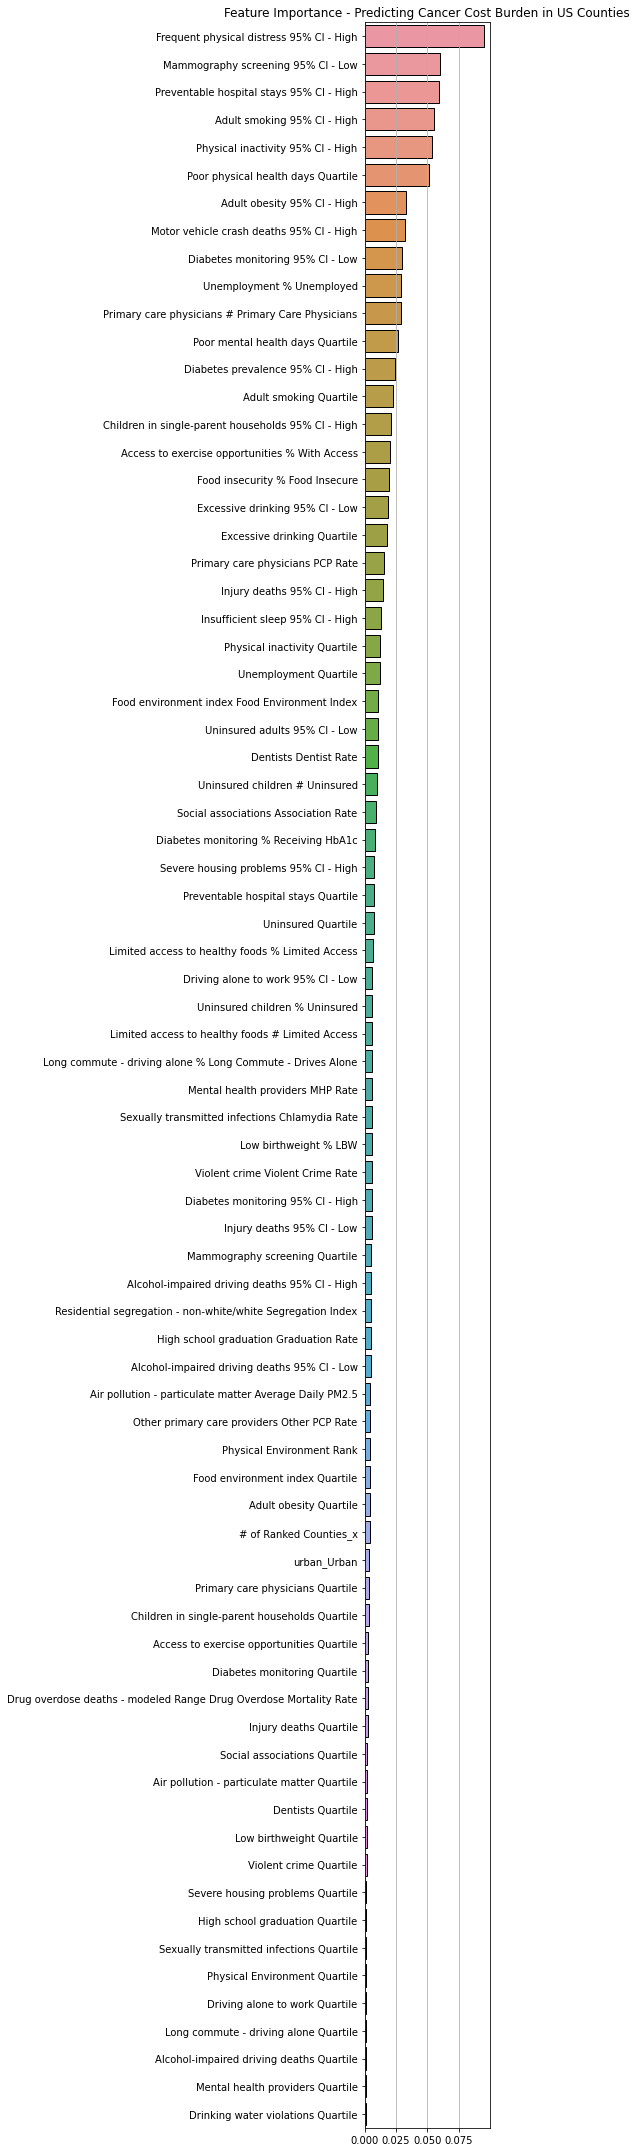

In [16]:
# PLOT
# Get sorted index of features based on importance (negate so the list is highest to lowest)
ind = np.argsort(-forest2.feature_importances_)

# Plot bar chart of importances
fig, ax = plt.subplots(figsize = (7,30))
plt.grid()
sns.barplot(x = forest2.feature_importances_[ind], y = list(X2.columns[ind]), ax = ax, edgecolor = 'black')
plt.title('Feature Importance - Predicting Cancer Cost Burden in US Counties');
plt.savefig('feature_importance_pred_cancer_cost_burden_randforest_uncorr_feats.png')

-------
# Now build a new model but with only the top 20% of features of previous model, based on importance

In [17]:
# Set indices to keep, i.e. the top 1/3 of all features in terms of importance
feats2keep = ind[0:round(len(ind)*.3333)]

# Set the X (predictor) and y (target) variables
X3 = X2.iloc[:,feats2keep]
y3 = costs_inc_mdl.abv_avg_ca

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X3, y3, random_state = 6, test_size = 0.1)

In [18]:
# TRAIN
forest3 = RandomForestClassifier(n_estimators = 1000, max_depth = 10, min_samples_leaf = 10)
forest3.fit(X_train, y_train)
y_pred_train = forest3.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))
y_pred = forest3.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8917010005885815
0.8624338624338624


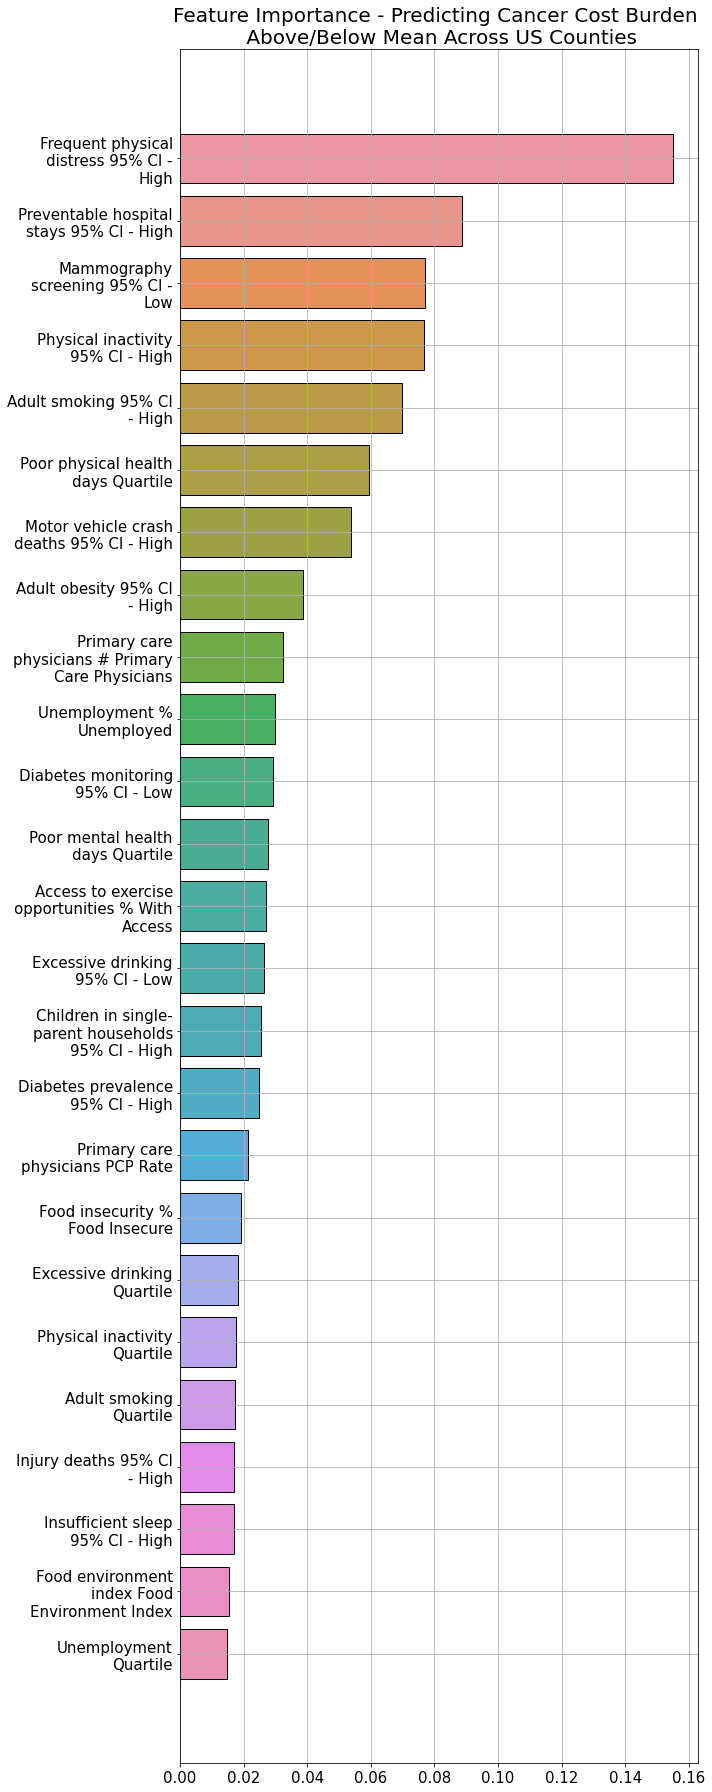

In [19]:
# PLOT

# Get the sorted index
ind = np.argsort(-abs(forest3.feature_importances_))

# Do tick label wrapping
labels= list(X3.columns[ind])
labels = [ '\n'.join(wrap(l, 20)) for l in labels ]

# Plot the resulting coefficients 
fig, ax = plt.subplots(figsize = (10,25))
ax.tick_params(labelsize=15)
sns.barplot(x = forest3.feature_importances_[ind], y = labels, ax = ax, edgecolor = 'black')

plt.title('Feature Importance - Predicting Cancer Cost Burden \n Above/Below Mean Across US Counties',fontsize=20)
ymin, ymax = plt.ylim()
plt.vlines(x = 0, ymin = ymin, ymax = ymax);
plt.grid()
plt.savefig('feature_importance_pred_cancer_cost_burden_randforest_top3rd.png')


### Above, we  plot a subset of the feature importances. We see some features that may be expected to contribute to cancer cost burden, such as inactivity, obesity, and smoking, but other interesting results as well, including a high importance of mammography screenings and preventable hospital stays.

-------
# Now let's check how good the binary predictions are for TN counties

In [20]:
## Get predictions for only TN counties
# Set the input feature matrix (X) and predicted variable (y)
X_tmp = X2
y_tmp = y2
forest_tmp = forest2

# Get the original dataframe for only TN counties
ci_TN = cost_income_rank_df[cost_income_rank_df.State == 'TN']
# Use index to select the features matrix for TN counties
X_TN = X_tmp[X_tmp.index.isin(ci_TN.index)]
# Get the outcome column based on index
y_TN = y_tmp[y_tmp.index.isin(ci_TN.index)]
# Predict the values of interest based on fitted model
y_pred_TN = forest_tmp.predict(X_TN)
print(metrics.accuracy_score(y_TN, y_pred_TN))

0.8947368421052632


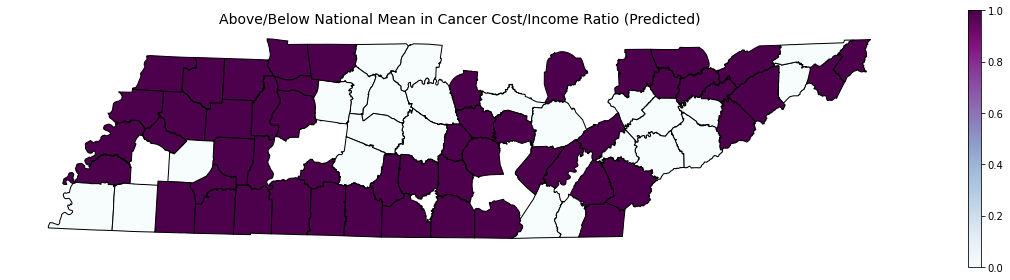

In [21]:
# PLOT 

# Load county data
counties = gpd.read_file('../data/county/tncounty.shp')
counties['State'] = 'TN';

# Combine the model and prediction variables
X_TN['ca_burden_pred'] = y_pred_TN
X_TN['ca_burden'] = y_TN
X_TN_all = X_TN.join(cost_income_rank_df,how='inner',lsuffix='_left', rsuffix='_right')

# Combine with geopandas dataframe
geo_tn_pred = pd.merge(left = counties, right = X_TN_all, 
                  left_on = ['State','NAME'], right_on = ['State','County'], how = 'inner')
fig, ax = plt.subplots(figsize=(16,4))
geo_tn_pred.plot(column = 'ca_burden_pred', 
              cmap = 'BuPu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax, vmin=0, vmax=1) #[geo_tn_pred.cancer_cost_inc_ratio.notnull()]
plt.title('Above/Below National Mean in Cancer Cost/Income Ratio (Predicted)', fontsize = 14)
ax.axis('off');
plt.savefig('abv_below_national_mean_cancer_cost_to_inc_ratio_TN_predicted_randforestclss.png')

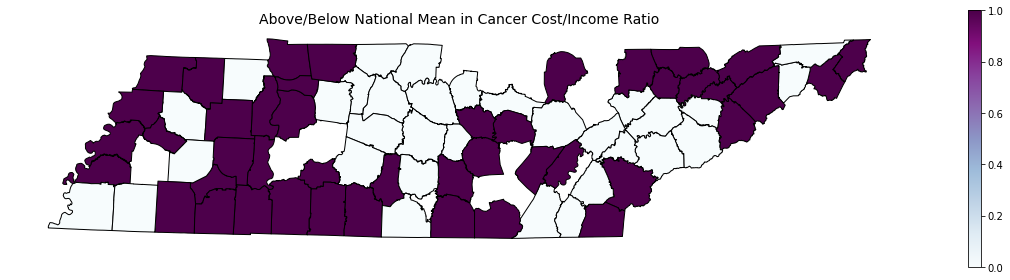

In [22]:
fig, ax = plt.subplots(figsize=(16,4))
geo_tn_pred.plot(column = 'ca_burden', 
              cmap = 'BuPu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax, vmin=0, vmax=1) #[geo_tn_pred.cancer_cost_inc_ratio.notnull()]
plt.title('Above/Below National Mean in Cancer Cost/Income Ratio', fontsize = 14)
ax.axis('off');
plt.savefig('abv_below_national_mean_cancer_cost_to_inc_ratio_TN_randforestclss.png')

------------------
# Interim Summary 
### We first used a random forest classification model to predict whether or not a county was above or below the nationwide mean in cancer cost burden (that is, the cancer cost to income ratio). We used the publicly available Health Rankings dataset from 2018, which included a total of 292 variables (which I will refer to as “features”). We trimmed this dataset down to 152 features (Model 1) that were relatively specific and  “actionable” (or modifiable). For instance, we removed features describing the demographics of each county and, included sub-measures in favor of their less specific summary measures. We also removed features directly related to average incomes, for example poverty levels. In Model 2, we removed features which were correlated at an R value of .9 or greater, keeping the more important feature in each case. For our final model, Model 3, we kept only the top third of features from Model 2 based on importance. You can see that at each step the overall accuracy on the test set improved (from about 80 to 86%), while accuracy on the training set stayed consistent (around 89%). The similar accuracy between the training and testing set in the final model is a good sign and indicates a low degree of overfitting.


### To understand more specifically how well the classifier performed for Tennessee counties, we plotted the true classifications and predicted classifications below. You can appreciate qualitatively how well the model is performing, and ultimately shows an accuracy in Tennessee of ~90%.

### We noted an interesting trend where cancer costs burdens were relatively lower surrounding major metropolitan areas including Memphis, Nashville, and Knoxville.

### [Technical note: Not all TN counties are plotted, because some were excluded from modelling due to having a null value in at least one retained feature]

--------------------

# Digging further

### Despite the success of this classification model, we wanted to further validate our findings with another approach, and importantly, delineate the *directionality* of the relationships between these features and cancer cost burden.

### For this we adopted a linear regression approach, using the same features from the final classification model. Importantly, here the predicted variable is the actual cost/income ratio, instead of the binary above/below the national mean variable

-------
# Run a normal linear regression - use standardization to ensure the beta coefficients more interpretable in comparison to each other

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Set the X (predictor) and y (target) variables
X5 = X3;

# Standardize features
# the scaler object (model)
scaler = StandardScaler()
# fit and transform the data
X5_scl = scaler.fit_transform(X5) 
X5.iloc[:,:] = X5_scl

y_lin = costs_inc_mdl.cancer_cost_inc_ratio

# Use all data for "training" given this is simple linear regression
X_train = X5;
y_train = y_lin;

linear_reg_mdl =  LinearRegression()
linear_reg_mdl.fit(X_train, y_train)

LinearRegression()

<AxesSubplot:>

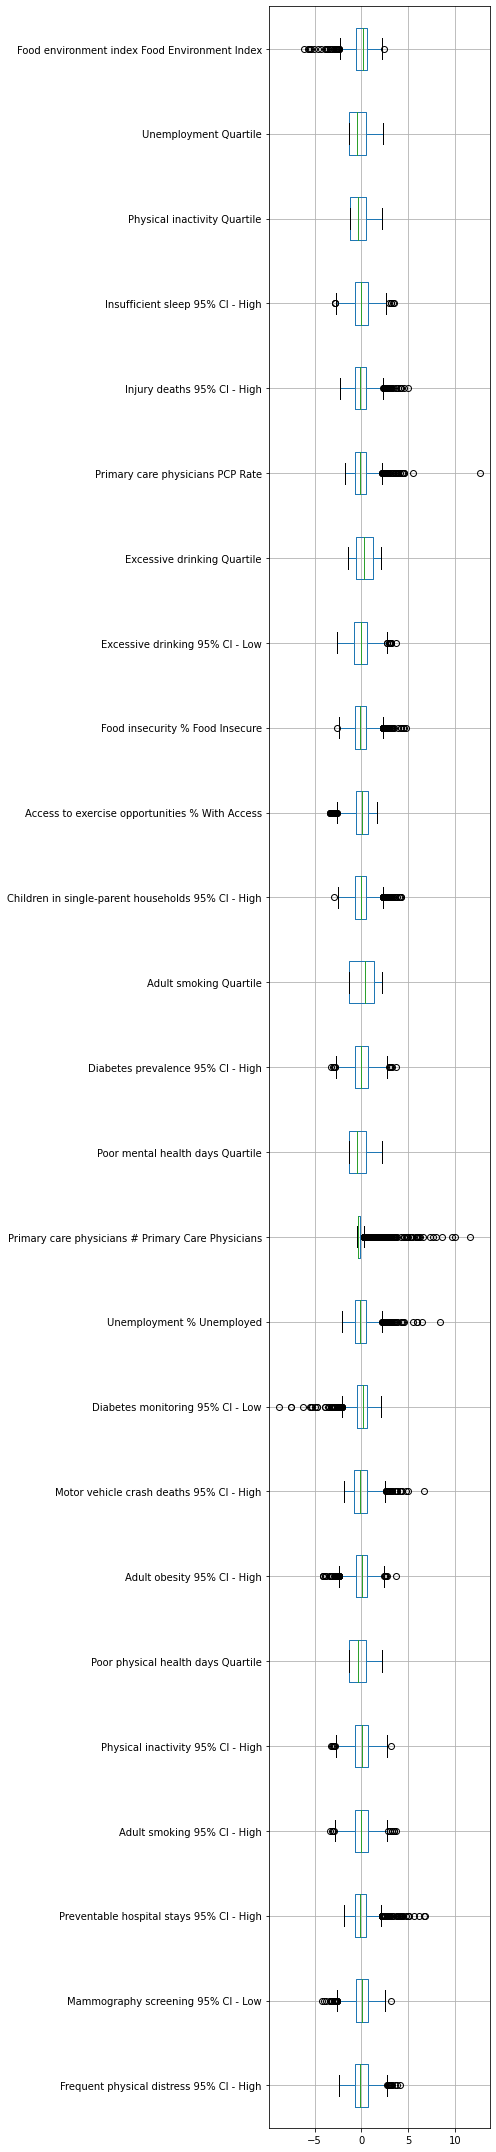

In [24]:
# Check that feature standardization worked
fig, ax = plt.subplots(figsize = (7,30))
X5.boxplot(vert=False)

R-squared (training set) =  0.6687021864102467
MSE (training set) =  0.0034666000361332325


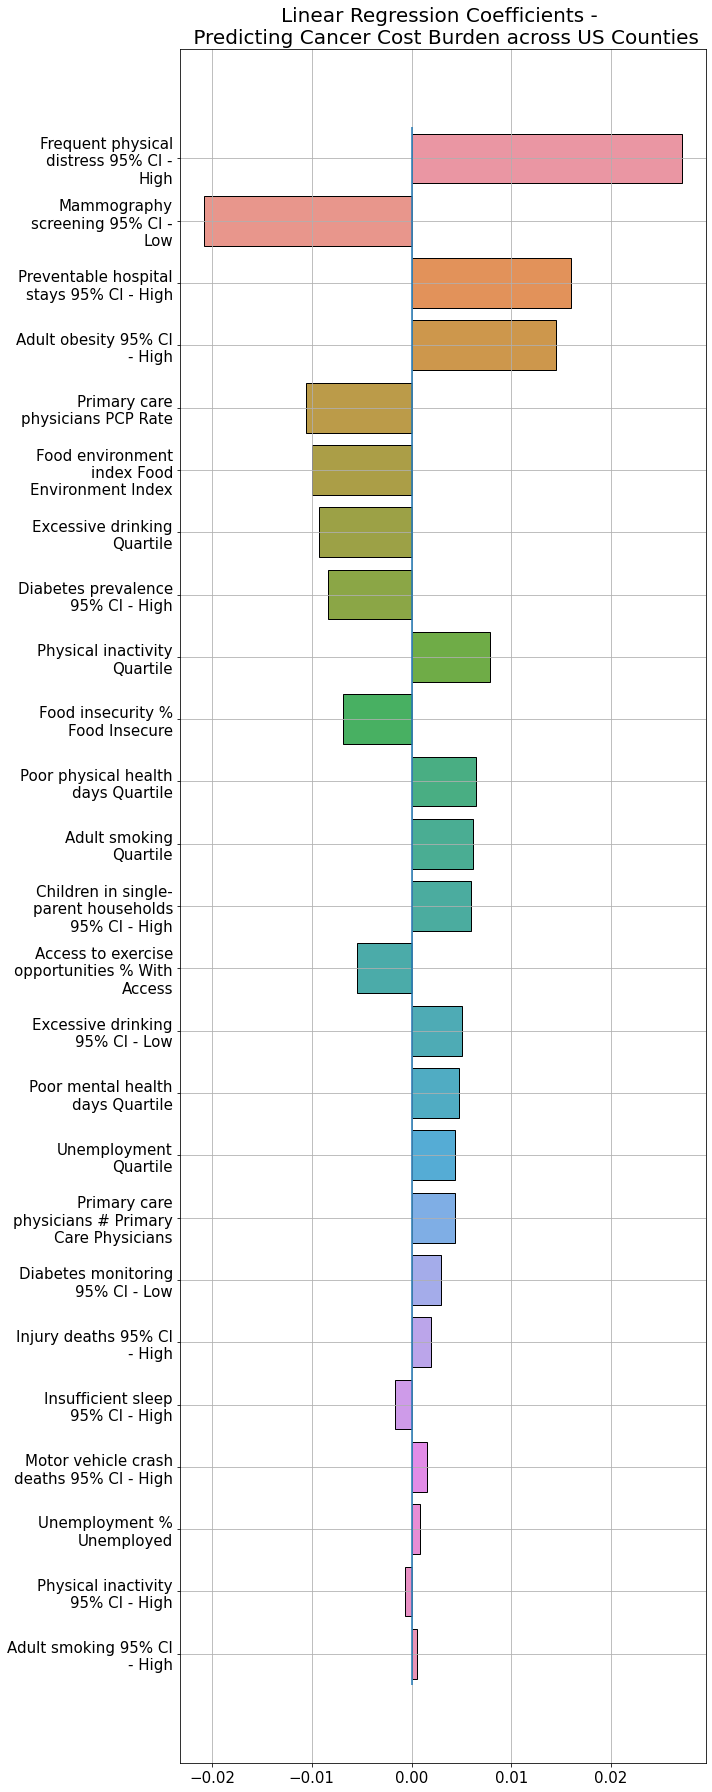

In [25]:
# Assess model
y_pred_train = linear_reg_mdl.predict(X_train)
print('R-squared (training set) = ', metrics.r2_score(y_train, y_pred_train))
print('MSE (training set) = ', metrics.mean_squared_error(y_train, y_pred_train))
y_pred = linear_reg_mdl.predict(X_test)

# Get the sorted index
ind = np.argsort(-abs(linear_reg_mdl.coef_))

# Do tick label wrapping
labels= list(X5.columns[ind])
labels = [ '\n'.join(wrap(l, 20)) for l in labels ]

# Plot the resulting coefficients 
fig, ax = plt.subplots(figsize = (10,25))
ax.tick_params(labelsize=15)
sns.barplot(x = linear_reg_mdl.coef_[ind], y = labels, ax = ax, edgecolor = 'black')

plt.title('Linear Regression Coefficients - \n Predicting Cancer Cost Burden across US Counties',fontsize=20)
ymin, ymax = plt.ylim()
plt.vlines(x = 0, ymin = ymin, ymax = ymax);
plt.grid()
plt.savefig('feature_importance_pred_cancer_cost_burden_linearreg.png')


### This model resulted in a high R-squared and relatively low mean squared error. Above, we plot the features ranked by their model coefficients. As expected many of the top features are overlapping with those from the classification model, indicating robustness to the type of modelling. But we also get additional information about the directionality of each feature’s effect. For instance, a higher cancer cost burden related to higher level of reported physical distress and lower levels of mammography screening. 

### [Technical note: Since this is a simple linear regression model, we aren’t concerned about overfitting. So, the model was fit using all US counties, as opposed to splitting into training and testing sets.]


-------
# Now let's check how good our (continuous) predictions are for TN counties

## Load/prepare geopandas data for plotting, then plot the calculated cost burden for all counties

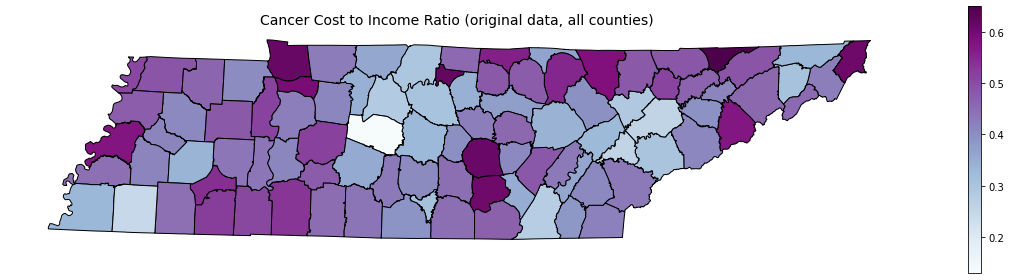

In [26]:
counties = gpd.read_file('../data/county/tncounty.shp')
counties['State'] = 'TN';
# Merge the original dataframe with geopandas data
geo_tn = pd.merge(left = counties, right = cost_income_rank_df, 
                  left_on = ['State','NAME'], right_on = ['State','County'], how = 'inner')

# Plot
fig, ax = plt.subplots(figsize=(16,4))
geo_tn[geo_tn.cancer_cost_inc_ratio.notnull()].plot(column = 'cancer_cost_inc_ratio', 
              cmap = 'BuPu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax,vmin=0.13, vmax=0.65)
plt.title('Cancer Cost to Income Ratio (original data, all counties) ', fontsize = 14)
ax.axis('off');

plt.savefig('cancer_cost_to_inc_ratio_TN_true_calculated_all_counties.png')


## Use model to predict burden for only TN counties (reduced set from random forest model)

In [27]:
## Get predictions for only TN counties
# Set the input feature matrix (X) and predicted variable (y)
X_tmp = X5
y_tmp = y_lin
# Get the original dataframe for only TN counties
ci_TN = cost_income_rank_df[cost_income_rank_df.State == 'TN']
# Use index to select the features matrix for TN counties
X_TN = X_tmp[X_tmp.index.isin(ci_TN.index)]
# Get the outcome column based on index
y_TN = y_tmp[y_tmp.index.isin(ci_TN.index)]
# Predict the values of interest based on fitted model
y_pred_TN = linear_reg_mdl.predict(X_TN)
print('R-squared (testing set) = ', metrics.r2_score(y_TN, y_pred_TN))
print('MSE (testing set) = ', metrics.mean_squared_error(y_TN, y_pred_TN))

R-squared (testing set) =  0.6352645753838551
MSE (testing set) =  0.0031754651534300943


In [28]:
# Combine the model and prediction variables
X_TN['ca_burden_pred'] = y_pred_TN
X_TN['ca_burden'] = y_TN
X_TN_all = X_TN.join(cost_income_rank_df,how='inner',lsuffix='_left', rsuffix='_right')

# Combine with geopandas dataframe
geo_tn_pred = pd.merge(left = counties, right = X_TN_all, 
                  left_on = ['State','NAME'], right_on = ['State','County'], how = 'inner')

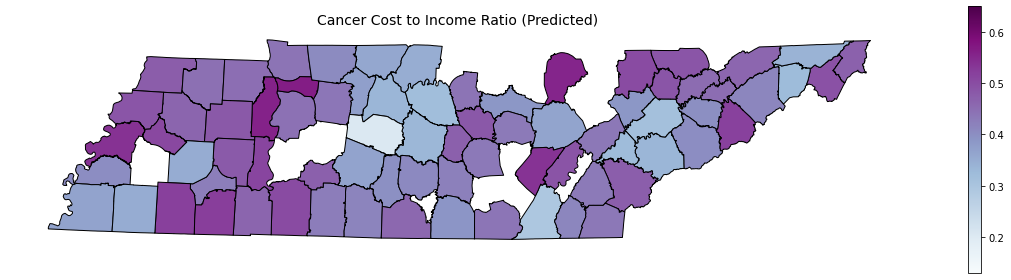

In [29]:
# Plot map of predicted values
fig, ax = plt.subplots(figsize=(16,4))
geo_tn_pred.plot(column = 'ca_burden_pred', 
              cmap = 'BuPu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax, vmin=0.13, vmax=0.65) 
plt.title('Cancer Cost to Income Ratio (Predicted) ', fontsize = 14)
ax.axis('off');

plt.savefig('cancer_cost_to_inc_ratio_TN_predicted_linreg.png')

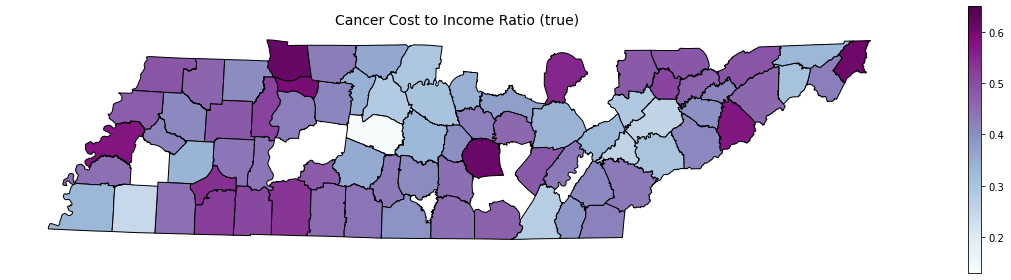

In [30]:
# Plot map of true values
fig, ax = plt.subplots(figsize=(16,4))
geo_tn_pred.plot(column = 'ca_burden', 
              cmap = 'BuPu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax, vmin=0.13, vmax=0.65) 
plt.title('Cancer Cost to Income Ratio (true) ', fontsize = 14)
ax.axis('off');

plt.savefig('cancer_cost_to_inc_ratio_TN_true_linreg.png')

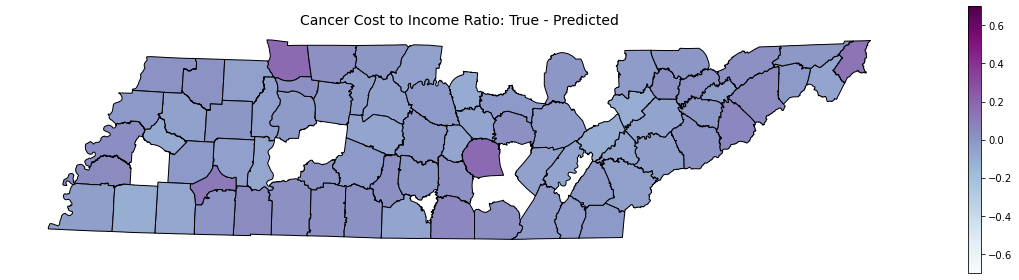

In [31]:
# Plot the difference map
geo_tn_pred['diff_in_pred'] = geo_tn_pred.ca_burden - geo_tn_pred.ca_burden_pred;
fig, ax = plt.subplots(figsize=(16,4))
geo_tn_pred.plot(column = 'diff_in_pred', 
              cmap = 'BuPu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax, vmin=-0.7, vmax=0.7) 
plt.title('Cancer Cost to Income Ratio: True - Predicted', fontsize = 14)
ax.axis('off');

### Here, we plot the actual and predicted cancer cost burdens across Tennessee counties. With few exceptions, the regression model performed well and showed similar performance metrics (R-squared) when looking at only Tennessee counties compared to the full model. This indicates that the trends we observe across all US counties are relatively consistent for Tennessee, and gives us more confidence that our analysis is relevant for TN Med Helper. 